# Classification

In this notebook a pretrained BERT model is finetuned to do sequence level classification based on the CONLL dataset. For that, first labels must be generated using the API of gpt 4o mini. Notebook partly based on https://huggingface.co/docs/transformers/tasks/sequence_classification

In [ ]:
# if running in a google colab, first install relevant packages 
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state informatio

In [ ]:
# import relevant packages
from openai import OpenAI
from datasets import load_dataset
from tqdm.auto import tqdm
from google.colab import files
from datasets import Dataset
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score
import evaluate
import matplotlib.pyplot as plt

### Generate labels using GPT

Start by generating labels für the sequences of the CONLL dataset using the API of gpt 4o mini. For that, we first need to join the words of the CONLL dataset to form a sequence. 

In [ ]:
# insert api key
# here redacted for obvious reasons
client = OpenAI(api_key="redacted")

In [ ]:
# function to form a sequence from a list of strings
def smart_join(strings):
    result = []
    for i, s in enumerate(strings):
        # Add a space before appending if the previous item is not a special character
        if i > 0 and not strings[i-1].endswith(('(', ' ')) and not s.startswith(('.', ',',';', ':', '%', """'""", '''"''', ')', '!', '?')):
            result.append(' ')

        result.append(s)

    return ''.join(result)

# Example usage
strings = ["This", "is", "a", "test", ",", "Isn", "'", "t"]
print(smart_join(strings))

This is a test, Isn' t


In [ ]:
# load train, validation and test data
ds_train = load_dataset("conll2003", split="train")
ds_valid = load_dataset("conll2003", split="validation")
ds_test = load_dataset("conll2003", split="test")

# select only 1000 samples of training set to save memory and compute 
training_classification = ds_train.shuffle(seed=23).select(range(1000))
training_tokens = training_classification['tokens']

# join training sequences
training_sentences = []
for t in training_tokens[:1000]:
  sentence = smart_join(t)
  training_sentences.append(sentence)

# select only 200 samples of validation set to save memory and compute    
validation_classification = ds_valid.shuffle(seed=23).select(range(200))
validation_tokens = validation_classification['tokens']

# join validation sequences
validation_sentences = []
for t in validation_tokens[:1000]:
  sentence = smart_join(t)
  validation_sentences.append(sentence)

# select only 1000 samples of test set to save memory and compute
test_classification = ds_test.shuffle(seed=23).select(range(200))
test_tokens = test_classification['tokens']

# join test sequences
test_sentences = []
for t in test_tokens[:1000]:
  sentence = smart_join(t)
  test_sentences.append(sentence)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Create a prompt to generate labels of the list (0: 'World', 1: 'Sport', 2: 'Business', 3: 'Technology', 4: 'Other') for the joined sequences. As with all prompt engineering this took a lot of trial and error, i.e., looking if the generated prompts match.

In [ ]:
#prombt = '''The goal is to create a dataset for document classification. Documents are classified based on their topic: 'World', 'Sport', 'Business', 'Technology' or 'Other'. Label the following sentence from 0 to 4 according to the following topic classification
#(0: 'World', 1: 'Sport', 2: 'Business', 3: 'Technology', 4: 'Other').
#Output format: integer label between 0 and 4.
#Examples:
#Input: 'The following bond was announced by lead manager Toronto Dominion.' Output: 2
#Input: 'Waldbaum Hamlet Cup tennis tournament on Wednesday.' Output: 1
#Input: 'Israel plays down fears of war with Syria .' Output: 0
#Input: 'Researchers report progress in muscular dystrophy .' Ouput: 3
#Input: '''


#prombt = '''The goal is to create a dataset for document classification. The documents are classified based on their topics: 'World', 'Sport', 'Business', 'Technology' or 'Other'.
#Label the following sentence from 0 to 4 according to the following topic classification
#(0: 'World', 1: 'Sport', 2: 'Business', 3: 'Technology', 4: 'Other'). Output format: integer label between 0 and 4. Input: '''

# final used prompt
prombt = '''
Task: Classify the given document based on its topic into one of the following categories:
0: World
1: Sport
2: Business
3: Technology
4: Other
Instructions: Analyze the content of the input sentence and assign the appropriate topic label as an integer (0 to 4).
Output Format: A single integer (0, 1, 2, 3, or 4) representing the most relevant topic category.
Input:'''

# sentence to test the prompt
sentence = 'The ferry, which was towed into port, had been bound for Jersey, another in a cluster of small British-ruled islands off north-west France.'
#'Asked what India would do if the pact were forwarded to the United Nations General Assembly, Gujral said:" That bridge I will cross when I come to it."'
#"James Harvey and Jennifer Hurley of the Moss Landing Marine Laboratories in California say their sea lions, natural companions of many species of whale, can go where no man or woman has ever gone before."

# run gpt to generate prompts
# temperature set to 0.2 to minimize hallucinations
# maximum one completion token (a number)
chat_completion = client.chat.completions.create(
  model="gpt-4o-mini",
  temperature=0.2,
  max_completion_tokens = 1,
  messages=[{"role": "user", "content": prombt + sentence + 'Output: '}]
)

response = int(chat_completion.choices[0].message.content)
print(response)

0


In [ ]:
# generate labels for th training set

# final prompt
prombt = '''
Task: Classify the given document based on its topic into one of the following categories:
0: World
1: Sport
2: Business
3: Technology
4: Other
Instructions: Analyze the content of the input sentence and assign the appropriate topic label as an integer (0 to 4).
Output Format: A single integer (0, 1, 2, 3, or 4) representing the most relevant topic category.
Input:'''

training_sentence_labels = []

# iterate over training samples and generate a label for each
for sentence in tqdm(training_sentences):

  chat_completion = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.2,
    max_completion_tokens = 1,
    messages=[{"role": "user", "content": prombt + sentence + 'Output: '}]
  )

  response = int(chat_completion.choices[0].message.content)

  training_sentence_labels.append(response)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
training_sentence_labels = sentence_labels.copy()

In [ ]:
# print finished labels for future use
print(training_sentence_labels)

[2, 4, 4, 1, 4, 4, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 0, 2, 4, 4, 1, 4, 4, 4, 2, 1, 1, 0, 4, 1, 2, 1, 0, 4, 4, 1, 4, 1, 0, 0, 1, 1, 0, 1, 0, 4, 1, 1, 1, 2, 1, 4, 4, 0, 1, 0, 2, 4, 4, 4, 1, 2, 0, 1, 1, 1, 0, 4, 1, 1, 2, 4, 4, 0, 1, 2, 1, 4, 1, 4, 1, 2, 0, 0, 1, 1, 4, 1, 2, 4, 0, 1, 1, 4, 4, 0, 2, 1, 4, 4, 0, 1, 0, 2, 4, 1, 1, 1, 2, 1, 1, 4, 0, 1, 1, 0, 4, 4, 1, 0, 2, 1, 2, 1, 0, 0, 1, 1, 1, 2, 4, 1, 1, 2, 2, 1, 0, 1, 1, 4, 2, 2, 1, 4, 2, 3, 4, 4, 0, 2, 4, 1, 0, 4, 1, 4, 4, 0, 4, 4, 1, 2, 1, 1, 1, 0, 4, 0, 1, 2, 2, 1, 4, 2, 2, 2, 2, 1, 4, 1, 2, 4, 0, 2, 4, 1, 2, 2, 4, 2, 4, 4, 0, 2, 0, 4, 4, 4, 4, 2, 1, 4, 1, 1, 2, 1, 4, 0, 1, 4, 2, 2, 4, 0, 2, 0, 1, 1, 1, 4, 4, 0, 2, 0, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 4, 4, 4, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 0, 1, 1, 4, 4, 1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 4, 4, 2, 4, 2, 4, 0, 4, 1, 0, 1, 4, 2, 4, 4, 4, 4, 4, 0, 1, 1, 4, 1, 4, 0, 1, 1, 2, 1, 0, 0, 0, 4, 4, 1, 4, 2, 4, 1, 0, 4, 4, 0, 0, 0, 2, 4, 1, 2, 2, 1, 3, 4, 4, 2, 0, 0, 0, 4, 1, 0, 1, 4, 

In [ ]:
# iterate over validation samples and generate a label for each
validation_sentence_labels = []

for sentence in tqdm(validation_sentences):

  chat_completion = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.2,
    max_completion_tokens = 1,
    messages=[{"role": "user", "content": prombt + sentence + 'Output: '}]
  )

  response = int(chat_completion.choices[0].message.content)

  validation_sentence_labels.append(response)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# print finished labels for future use
print(validation_sentence_labels)

[0, 0, 1, 1, 4, 4, 1, 2, 1, 4, 2, 1, 0, 1, 0, 2, 1, 1, 1, 3, 1, 0, 4, 0, 4, 4, 3, 0, 1, 2, 1, 2, 0, 0, 1, 2, 1, 4, 1, 1, 4, 1, 1, 1, 1, 0, 4, 4, 2, 4, 2, 2, 1, 2, 1, 1, 2, 4, 1, 1, 4, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 4, 0, 4, 1, 0, 1, 0, 2, 4, 1, 0, 1, 1, 1, 1, 0, 1, 1, 4, 2, 1, 0, 4, 4, 4, 1, 4, 1, 0, 4, 1, 1, 0, 1, 0, 2, 1, 1, 4, 0, 1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 1, 1, 1, 4, 4, 4, 4, 0, 0, 2, 1, 4, 1, 1, 4, 0, 1, 4, 4, 1, 0, 1, 1, 0, 0, 4, 2, 4, 4, 4, 1, 4, 1, 4, 1, 0, 2, 4, 4, 2, 1, 4, 2, 4, 2, 1, 0, 0, 4, 1, 1, 0, 1, 4, 1, 2, 1, 2, 0, 1, 1, 4, 4, 4, 1, 4, 0, 0, 0, 0, 1, 1, 1]


In [ ]:
# iterate over test samples and generate a label for each
test_sentence_labels = []

for sentence in tqdm(test_sentences):

  chat_completion = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.2,
    max_completion_tokens = 1,
    messages=[{"role": "user", "content": prombt + sentence + 'Output: '}]
  )

  response = int(chat_completion.choices[0].message.content)

  test_sentence_labels.append(response)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# print finished labels for future use
print(test_sentence_labels)

[1, 1, 2, 2, 1, 4, 1, 4, 1, 1, 1, 2, 1, 4, 4, 2, 1, 0, 1, 4, 1, 4, 4, 1, 2, 1, 1, 0, 1, 1, 1, 2, 4, 1, 4, 0, 1, 0, 2, 4, 1, 2, 4, 2, 0, 1, 1, 2, 4, 1, 4, 2, 2, 4, 4, 2, 4, 1, 4, 1, 2, 0, 1, 4, 1, 2, 0, 4, 0, 2, 0, 2, 2, 1, 4, 4, 2, 4, 2, 1, 1, 1, 4, 2, 1, 1, 1, 1, 4, 4, 4, 1, 2, 1, 2, 1, 1, 1, 4, 2, 4, 1, 0, 1, 4, 2, 1, 1, 4, 0, 1, 2, 2, 4, 4, 1, 4, 4, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 0, 1, 4, 4, 2, 1, 0, 4, 4, 4, 2, 1, 4, 0, 1, 1, 1, 1, 1, 1, 2, 4, 4, 1, 1, 4, 4, 2, 0, 4, 2, 1, 4, 4, 1, 0, 0, 4, 0, 4, 2, 2, 4, 2, 1, 1, 1, 4, 1, 0, 1, 1, 1, 1, 0, 2, 4, 1, 4, 4, 4, 4, 1, 4, 3, 4, 2, 1]


In [ ]:
# load finished labels
training_sentence_labels = [2, 4, 4, 1, 4, 4, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 0, 2, 4, 4, 1, 4, 4, 4, 2, 1, 1, 0, 4, 1, 2, 1, 0, 4, 4, 1, 4, 1, 0, 0, 1, 1, 0, 1, 0, 4, 1, 1, 1, 2, 1, 4, 4, 0, 1, 0, 2, 4, 4, 4, 1, 2, 0, 1, 1, 1, 0, 4, 1, 1, 2, 4, 4, 0, 1, 2, 1, 4, 1, 4, 1, 2, 0, 0, 1, 1, 4, 1, 2, 4, 0, 1, 1, 4, 4, 0, 2, 1, 4, 4, 0, 1, 0, 2, 4, 1, 1, 1, 2, 1, 1, 4, 0, 1, 1, 0, 4, 4, 1, 0, 2, 1, 2, 1, 0, 0, 1, 1, 1, 2, 4, 1, 1, 2, 2, 1, 0, 1, 1, 4, 2, 2, 1, 4, 2, 3, 4, 4, 0, 2, 4, 1, 0, 4, 1, 4, 4, 0, 4, 4, 1, 2, 1, 1, 1, 0, 4, 0, 1, 2, 2, 1, 4, 2, 2, 2, 2, 1, 4, 1, 2, 4, 0, 2, 4, 1, 2, 2, 4, 2, 4, 4, 0, 2, 0, 4, 4, 4, 4, 2, 1, 4, 1, 1, 2, 1, 4, 0, 1, 4, 2, 2, 4, 0, 2, 0, 1, 1, 1, 4, 4, 0, 2, 0, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 4, 4, 4, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 0, 1, 1, 4, 4, 1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 4, 4, 2, 4, 2, 4, 0, 4, 1, 0, 1, 4, 2, 4, 4, 4, 4, 4, 0, 1, 1, 4, 1, 4, 0, 1, 1, 2, 1, 0, 0, 0, 4, 4, 1, 4, 2, 4, 1, 0, 4, 4, 0, 0, 0, 2, 4, 1, 2, 2, 1, 3, 4, 4, 2, 0, 0, 0, 4, 1, 0, 1, 4, 2, 2, 1, 4, 0, 0, 4, 0, 1, 4, 1, 0, 1, 4, 4, 4, 4, 0, 1, 0, 4, 1, 1, 0, 4, 0, 4, 1, 4, 2, 4, 2, 1, 4, 1, 4, 0, 1, 4, 0, 4, 0, 1, 0, 1, 4, 1, 2, 2, 4, 2, 2, 0, 4, 1, 4, 1, 2, 1, 4, 1, 2, 2, 1, 4, 4, 4, 2, 1, 4, 4, 0, 4, 4, 1, 1, 2, 2, 2, 1, 4, 1, 4, 1, 4, 0, 2, 1, 2, 4, 4, 0, 1, 2, 0, 0, 2, 0, 4, 2, 4, 1, 0, 2, 0, 2, 4, 2, 0, 0, 4, 0, 4, 1, 4, 1, 0, 1, 4, 0, 4, 4, 1, 0, 0, 0, 2, 1, 1, 4, 0, 2, 0, 1, 1, 4, 4, 0, 1, 1, 4, 1, 0, 1, 1, 1, 1, 0, 4, 1, 4, 4, 1, 2, 4, 2, 1, 1, 1, 1, 4, 4, 1, 2, 0, 1, 1, 1, 1, 1, 1, 4, 1, 2, 4, 0, 4, 1, 4, 1, 1, 0, 0, 2, 1, 4, 1, 4, 2, 0, 4, 0, 0, 1, 1, 4, 4, 2, 1, 1, 1, 0, 4, 2, 2, 0, 1, 4, 4, 1, 4, 4, 2, 4, 4, 2, 1, 1, 0, 2, 4, 0, 2, 1, 4, 0, 4, 0, 1, 0, 4, 4, 4, 0, 4, 1, 1, 4, 2, 1, 4, 1, 4, 2, 1, 4, 1, 4, 1, 4, 4, 2, 4, 4, 0, 1, 0, 2, 2, 4, 4, 4, 0, 1, 2, 1, 4, 1, 1, 2, 1, 4, 2, 4, 4, 1, 1, 1, 0, 3, 4, 0, 4, 1, 4, 0, 4, 1, 2, 1, 1, 4, 0, 0, 4, 2, 4, 1, 2, 4, 0, 0, 4, 4, 1, 4, 4, 0, 2, 1, 1, 1, 4, 0, 0, 4, 1, 4, 0, 4, 4, 1, 4, 1, 2, 1, 2, 4, 0, 1, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 0, 0, 0, 4, 0, 4, 4, 4, 2, 1, 2, 0, 2, 4, 0, 4, 4, 1, 1, 4, 4, 2, 2, 1, 1, 4, 1, 2, 4, 1, 1, 0, 1, 0, 2, 0, 4, 4, 0, 2, 0, 1, 0, 1, 1, 2, 1, 2, 4, 4, 1, 1, 1, 1, 2, 4, 4, 4, 2, 2, 4, 0, 4, 4, 4, 4, 4, 0, 4, 1, 0, 4, 1, 4, 4, 0, 0, 1, 0, 1, 0, 1, 4, 1, 4, 1, 1, 2, 1, 0, 1, 4, 2, 0, 4, 0, 2, 4, 0, 4, 1, 1, 4, 1, 0, 0, 1, 1, 4, 4, 0, 1, 0, 1, 2, 1, 2, 0, 0, 2, 0, 4, 2, 4, 2, 0, 2, 1, 4, 2, 2, 0, 4, 1, 0, 4, 1, 1, 1, 1, 4, 4, 2, 4, 2, 2, 1, 4, 1, 2, 4, 4, 4, 4, 4, 4, 0, 4, 1, 4, 2, 0, 4, 4, 1, 2, 1, 2, 0, 4, 4, 1, 0, 4, 4, 1, 1, 1, 1, 2, 4, 0, 1, 4, 1, 1, 0, 2, 0, 4, 1, 1, 0, 4, 4, 1, 1, 1, 4, 4, 1, 1, 1, 4, 1, 0, 1, 4, 0, 1, 1, 4, 4, 2, 2, 2, 0, 0, 2, 1, 4, 4, 1, 1, 2, 1, 1, 1, 0, 0, 4, 4, 0, 1, 0, 1, 4, 0, 1, 0, 4, 2, 0, 4, 1, 2, 2, 0, 1, 0, 1, 4, 2, 4, 0, 4, 2, 1, 4, 1, 0, 4, 4, 1, 1, 0, 4, 1, 0, 2, 4, 0, 1, 4, 0, 0, 4, 1, 1, 1, 2, 0, 4, 4, 0, 0, 4, 1, 4, 4, 1, 4, 0, 4, 4, 1, 1, 4, 1, 0, 4, 2, 0, 4, 1, 2, 0, 0, 4, 1, 4, 0, 0, 4, 1, 1, 1, 1, 4, 4, 1, 0, 4, 4, 4, 2, 4]
validation_sentence_labels = [0, 0, 1, 1, 4, 4, 1, 2, 1, 4, 2, 1, 0, 1, 0, 2, 1, 1, 1, 3, 1, 0, 4, 0, 4, 4, 3, 0, 1, 2, 1, 2, 0, 0, 1, 2, 1, 4, 1, 1, 4, 1, 1, 1, 1, 0, 4, 4, 2, 4, 2, 2, 1, 2, 1, 1, 2, 4, 1, 1, 4, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 4, 0, 4, 1, 0, 1, 0, 2, 4, 1, 0, 1, 1, 1, 1, 0, 1, 1, 4, 2, 1, 0, 4, 4, 4, 1, 4, 1, 0, 4, 1, 1, 0, 1, 0, 2, 1, 1, 4, 0, 1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 1, 1, 1, 4, 4, 4, 4, 0, 0, 2, 1, 4, 1, 1, 4, 0, 1, 4, 4, 1, 0, 1, 1, 0, 0, 4, 2, 4, 4, 4, 1, 4, 1, 4, 1, 0, 2, 4, 4, 2, 1, 4, 2, 4, 2, 1, 0, 0, 4, 1, 1, 0, 1, 4, 1, 2, 1, 2, 0, 1, 1, 4, 4, 4, 1, 4, 0, 0, 0, 0, 1, 1, 1]
test_sentence_labels = [1, 1, 2, 2, 1, 4, 1, 4, 1, 1, 1, 2, 1, 4, 4, 2, 1, 0, 1, 4, 1, 4, 4, 1, 2, 1, 1, 0, 1, 1, 1, 2, 4, 1, 4, 0, 1, 0, 2, 4, 1, 2, 4, 2, 0, 1, 1, 2, 4, 1, 4, 2, 2, 4, 4, 2, 4, 1, 4, 1, 2, 0, 1, 4, 1, 2, 0, 4, 0, 2, 0, 2, 2, 1, 4, 4, 2, 4, 2, 1, 1, 1, 4, 2, 1, 1, 1, 1, 4, 4, 4, 1, 2, 1, 2, 1, 1, 1, 4, 2, 4, 1, 0, 1, 4, 2, 1, 1, 4, 0, 1, 2, 2, 4, 4, 1, 4, 4, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 0, 1, 4, 4, 2, 1, 0, 4, 4, 4, 2, 1, 4, 0, 1, 1, 1, 1, 1, 1, 2, 4, 4, 1, 1, 4, 4, 2, 0, 4, 2, 1, 4, 4, 1, 0, 0, 4, 0, 4, 2, 2, 4, 2, 1, 1, 1, 4, 1, 0, 1, 1, 1, 1, 0, 2, 4, 1, 4, 4, 4, 4, 1, 4, 3, 4, 2, 1]

In [ ]:
label2class = {0: 'World', 1: 'Sport', 2: 'Business', 3: 'Technology', 4: 'Other'}

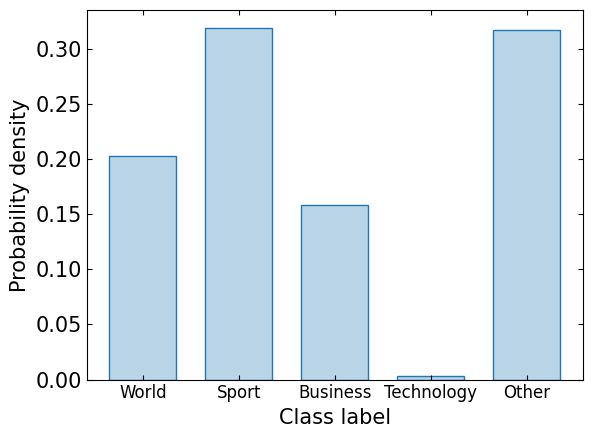

In [ ]:
# plot class distribution of generated training labels
# there are almost no sequences for the labels Technology
# and many in the label Other, some of which could have been avoided by setting the minimum number of string to > 2

_ = plt.hist(training_sentence_labels, bins=5, range=(-0.5,4.5), density=True, color=("C0", 0.3), edgecolor = "C0", rwidth=0.7)
plt.tick_params(top = 1 , right = 1, which = 'both', direction = 'in', labelsize=15)
plt.xlabel('Class label', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.xticks(ticks=[0,1,2,3,4], labels=['World', 'Sport', 'Business', 'Technology', 'Other'], fontsize=12)

plt.savefig('class_distribution.pdf', dpi=9600, bbox_inches = 'tight')
files.download('class_distribution.pdf');

### Training classifier

After generating labels, we now finetune a pretrained BERT model for sequence level token classification.

In [ ]:
# convert data to huggingface datasets
train_data = {}
train_data['sentences'] = training_sentences
train_data['labels'] = training_sentence_labels
train_data = Dataset.from_dict(train_data)

valid_data = {}
valid_data['sentences'] = validation_sentences
valid_data['labels'] = validation_sentence_labels
valid_data = Dataset.from_dict(valid_data)

test_data = {}
test_data['sentences'] = test_sentences
test_data['labels'] = test_sentence_labels
test_data = Dataset.from_dict(test_data)

# load bert tokenizer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["sentences"], truncation=True)

# and apply to datasets
tokenized_train_data = train_data.map(tokenize_function, batched=True)
tokenized_valid_data = valid_data.map(tokenize_function, batched=True)
tokenized_test_data = test_data.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# function to evaluate performance metrics (accuracy, f1 score) for training
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
# load pretrained BERT model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)

# set training arguments
training_args = TrainingArguments(
    "bert-finetuned-classification",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=4,
    weight_decay=0.01,
    push_to_hub=False,
    logging_steps=1
)

model_name = f"models/finetuned-bert-classification"
training_args.output_dir = model_name

# train model 
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_train_data,
                  eval_dataset=tokenized_valid_data,
                  data_collator=data_collator,
                  tokenizer=tokenizer)
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.906400,0.413044,0.880000,0.875834
2,0.014200,0.427442,0.870000,0.869465
3,0.009300,0.332395,0.920000,0.915544
4,0.003000,0.347189,0.920000,0.915585


TrainOutput(global_step=500, training_loss=0.3444980239244178, metrics={'train_runtime': 128.2281, 'train_samples_per_second': 31.194, 'train_steps_per_second': 3.899, 'total_flos': 84148470936768.0, 'train_loss': 0.3444980239244178, 'epoch': 4.0})

In [ ]:
# evaluate performance of the model
model.eval();

test_predictions = trainer.predict(tokenized_test_data)
test_predictions.metrics

{'test_loss': 0.5587901473045349,
 'test_accuracy': 0.87,
 'test_f1': 0.868632717472762,
 'test_runtime': 0.6319,
 'test_samples_per_second': 316.502,
 'test_steps_per_second': 39.563}

In [ ]:
# evaluate performance of the model for the different classes
for j in range(5):

  class_test_data = {}
  class_test_data['sentences'] = [test_sentences[i] for i,t in enumerate(test_sentence_labels) if t==j]
  class_test_data['labels'] = [t for i,t in enumerate(test_sentence_labels) if t==j]
  class_test_data = Dataset.from_dict(class_test_data)

  tokenized_class_test_data = class_test_data.map(tokenize_function, batched=True)
  class_test_predictions = trainer.predict(tokenized_class_test_data)
  print(j, '\t', class_test_predictions.metrics['test_f1'], '\t', class_test_predictions.metrics['test_accuracy'])

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

0 	 0.8947368421052632 	 0.8095238095238095


Map:   0%|          | 0/77 [00:00<?, ? examples/s]

1 	 0.9594594594594594 	 0.922077922077922


Map:   0%|          | 0/43 [00:00<?, ? examples/s]

2 	 0.8974358974358975 	 0.813953488372093


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

3 	 0.0 	 0.0


Map:   0%|          | 0/58 [00:00<?, ? examples/s]

4 	 0.9357798165137615 	 0.8793103448275862


In [ ]:
# compute confusion matrix
confusion_metric = evaluate.load("confusion_matrix")
results = confusion_metric.compute(references=test_predictions.predictions.argmax(-1), predictions=test_predictions.label_ids)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

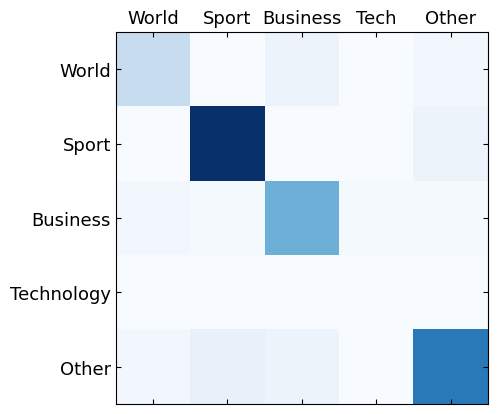

In [ ]:
# display confusion matrix
plt.matshow(results['confusion_matrix'], cmap='Blues')
plt.tick_params(top = 1 , right = 1, which = 'both', direction = 'in', labelsize=12)
plt.xticks(ticks=[0,1,2,3,4], labels=['World', 'Sport', 'Business', 'Tech', 'Other'], fontsize=13)
plt.yticks(ticks=[0,1,2,3,4], labels=['World', 'Sport', 'Business', 'Technology', 'Other'], fontsize=13)

plt.savefig('confusion_matrix.pdf', bbox_inches = 'tight')
files.download('confusion_matrix.pdf');